## RunModelsWithMedianEmbedding
This script:
- Reads the per-LSOA median embedding (from pickle files produced by script 3)
- Joins with IMD deprivation data
- Fits and evaluates a regression model (XGBoost) using cross-validation with hyperparameter tuning
- Tests out-of-sample performance on a held-out 20% test set
- Saves the best model for reuse

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*glibc.*")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
import joblib
import geopandas as gpd


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from xgboost import XGBRegressor


def evaluate_imd_model(y_true, y_pred, column, num_in_class=None, num_lsoas=None,
                        plot=True, plot_collectively=False, ax=None):
    """Compute regression metrics and optionally plot true vs predicted."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Spearman_rank_corr': spearman_corr}

    if plot:
        plt.figure(figsize=(6, 6))
        plt.scatter(y_true, y_pred, alpha=0.7)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        plt.xlabel(f"True {column}")
        plt.ylabel(f"Predicted {column}")
        plt.title(f"{column}")
        plt.grid(True)
        plt.show()

    if plot_collectively and ax is not None:
        ax.scatter(y_true, y_pred, alpha=0.7)
        ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        ax.set_xlabel("True")
        ax.set_ylabel("Predicted")
        ax.set_title(f"{column}: \n{num_in_class} images\n {num_lsoas} LSOAs", fontsize=15)
        ax.grid(True)
        ax.text(
            0.01, 0.99,
            f'R² = {r2:.2f}, RMSE = {rmse:.0f}',
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment='top',
            horizontalalignment='left')

    return metrics

In [2]:
from directory_filepaths import *

In [3]:
var_to_predict = 'imd_rerank'

In [4]:
statistic = 'median'

### Get imd data

In [5]:
imd = pd.read_excel(imd_file, sheet_name="IoD2025 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2021)": "LSOA21CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)
imd

,LSOA21CD,LSOA name (2021),Local Authority District code (2024),Local Authority District name (2024),imd_rank,imd_decile,Income Rank (where 1 is most deprived),Income Decile (where 1 is most deprived 10% of LSOAs),Employment Rank (where 1 is most deprived),Employment Decile (where 1 is most deprived 10% of LSOAs),"Education, Skills and Training Rank (where 1 is most deprived)","Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)",Health Deprivation and Disability Rank (where 1 is most deprived),Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs),Crime Rank (where 1 is most deprived),Crime Decile (where 1 is most deprived 10% of LSOAs),Barriers to Housing and Services Rank (where 1 is most deprived),Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs),Living Environment Rank (where 1 is most deprived),Living Environment Decile (where 1 is most deprived 10% of LSOAs)
0,E01000001,City of London 001A,E09000001,City of London,26525,8,33730,10,33708,10,33755,10,33108,10,33698,10,29220,9,244,1
1,E01000002,City of London 001B,E09000001,City of London,31203,10,33669,10,33734,10,33672,10,32574,10,33712,10,32640,10,3702,2
2,E01000003,City of London 001C,E09000001,City of London,25913,8,25167,8,26985,8,30273,9,20719,7,27325,9,30400,10,4540,2
3,E01000005,City of London 001E,E09000001,City of London,14807,5,14836,5,17911,6,15886,5,10458,4,25630,8,11294,4,5403,2
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,10917,4,7519,3,15286,5,11134,4,21901,7,17875,6,2745,1,9479,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33750,E01035758,Vale of White Horse 014H,E07000180,Vale of White Horse,27536,9,25934,8,24575,8,21842,7,29534,9,13583,5,23743,8,25435,8
33751,E01035759,Vale of White Horse 015G,E07000180,Vale of White Horse,27902,9,26440,8,22891,7,25326,8,25671,8,30130,9,12406,4,28626,9
33752,E01035760,Vale of White Horse 015H,E07000180,Vale of White Horse,27532,9,18127,6,26383,8,22625,7,26857,8,19110,6,30084,9,31180,10
33753,E01035761,Vale of White Horse 015I,E07000180,Vale of White Horse,28981,9,21596,7,29547,9,24267,8,28925,9,24825,8,18053,6,29506,9


### Sanity check: map IMD rank
Quick choropleth to verify the deprivation data looks sensible (e.g. central Manchester should be more deprived than suburban areas).

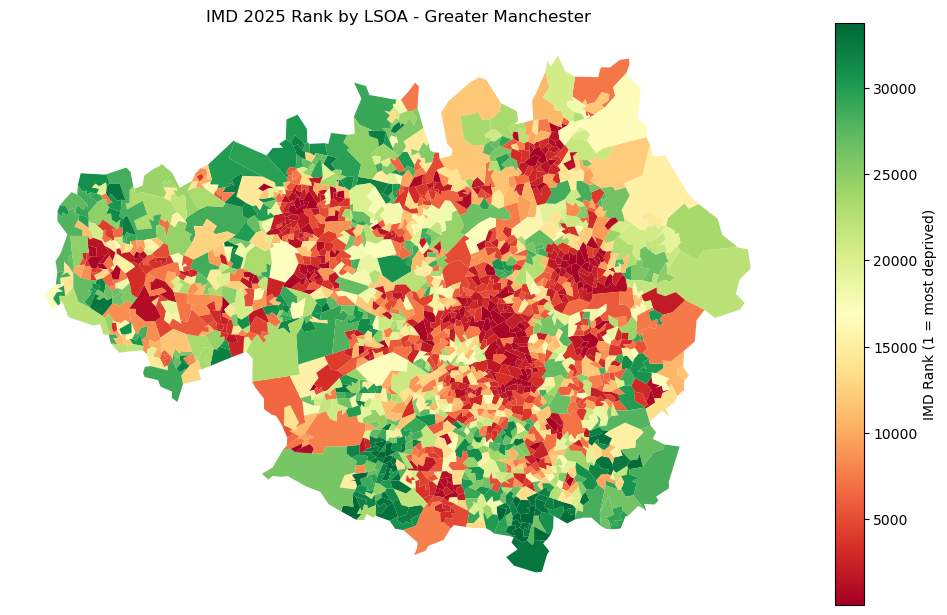

In [6]:

lsoas = gpd.read_file(lsoas_file)
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham', 'Trafford', 'Salford', 'Tameside', 'Stockport']
gm_lsoa = lsoas[lsoas['LSOA21NM'].str.contains('|'.join(manc_lads))].to_crs(epsg=4326)

gm_lsoa_imd = gm_lsoa.merge(imd[['LSOA21CD', 'imd_rank', 'imd_decile']], on='LSOA21CD', how='left')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gm_lsoa_imd.plot(
    column='imd_rank',
    cmap='RdYlGn',  # red = low rank (most deprived), green = high rank (least deprived)
    legend=True,
    legend_kwds={'label': 'IMD Rank (1 = most deprived)', 'shrink': 0.6},
    ax=ax)
ax.set_title('IMD 2025 Rank by LSOA - Greater Manchester')
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Get embedding data

In [7]:
embedding_pkl = os.path.join(data_dir, "per_lsoa_embedding_summaries", f"{statistic}_embedding.pkl")
big_summary_df = pd.read_pickle(embedding_pkl)

big_summary_df_with_imd = pd.merge(left=big_summary_df, right=imd[['LSOA21CD', 'imd_rank']], on="LSOA21CD")
big_summary_df_with_imd['imd_rerank'] = big_summary_df_with_imd['imd_rank'].rank(method='first').astype(int)

print(f"LSOAs with both embeddings and IMD data: {len(big_summary_df_with_imd)}")

LSOAs with both embeddings and IMD data: 1695


### Split the data into 80% training, 20% testing

In [8]:
X = np.stack(big_summary_df_with_imd[f"{statistic}_embedding"].values)     
y = big_summary_df_with_imd[var_to_predict].values

# -------------------------
# Split data into training and test sets
# -------------------------
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, np.arange(X.shape[0]), test_size=0.2, random_state=42)
print(f"Training points: {X_train.shape[0]}, Test points: {X_test.shape[0]}")

Training points: 1356, Test points: 339


### Perform model selection and hyper-parameter tuning using the 80% training data:

In [9]:
# Define model pipelines and parameter grids
# Each entry: (name, pipeline, param_grid)
model_configs = [
    ("XGBoost", Pipeline([
        ('scaler', StandardScaler()),
        ('reg', XGBRegressor(
            objective='reg:squarederror',  # minimise squared error (standard for regression)
            random_state=42,               # reproducible results
            n_jobs=-1,                     # use all CPU cores for training a single model
            verbosity=0))]),               # suppress XGBoost's own logging
     {
      'reg__n_estimators': [100, 300],         # number of boosting rounds (more = more complex)
      'reg__max_depth': [3, 6, 10],            # max tree depth (controls model complexity)
      'reg__learning_rate': [0.01, 0.1, 0.3],  # step size shrinkage (lower = slower but often better)
      'reg__subsample': [0.8, 1.0],            # fraction of training rows used per tree (< 1 adds regularisation)
     }),
]

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)
ncores = min(multiprocessing.cpu_count() - 1, 100)

best_model = None
best_score = -np.inf
best_model_name = None
best_params = {}

print(f"Training {len(model_configs)} model(s) using {ncores} cores")

for name, pipeline, param_grid in model_configs:
    # Calculate fits for progress reporting
    n_fits = 1
    for vals in param_grid.values():
        n_fits *= len(vals)
    n_fits *= cv.n_splits
    print(f"\nTraining: {name} ({n_fits} fits)...")

    # Main grid search code:
    grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='r2', n_jobs=ncores, verbose=1)
    grid.fit(X_train, y_train)

    print(f"  CV mean R² = {grid.best_score_:.3f}")
    print(f"  Best params: {grid.best_params_}")

    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_
        best_model_name = name
        best_params = grid.best_params_.copy()

print(f"\nBest model: {best_model_name} (CV R² = {best_score:.3f})")
print(f"Best hyperparameters: {best_params}")

Training 1 model(s) using 11 cores

Training: XGBoost (180 fits)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
  CV mean R² = 0.653
  Best params: {'reg__learning_rate': 0.1, 'reg__max_depth': 3, 'reg__n_estimators': 300, 'reg__subsample': 1.0}

Best model: XGBoost (CV R² = 0.653)
Best hyperparameters: {'reg__learning_rate': 0.1, 'reg__max_depth': 3, 'reg__n_estimators': 300, 'reg__subsample': 1.0}


In [10]:
# Save the best model
model_dir = os.path.join(data_dir, "best_model")
os.makedirs(model_dir, exist_ok=True)

bundle = {
    "model": best_model,
    "name": best_model_name,
    "cv_score_r2": float(best_score),
    "best_params": best_params,
}

model_path = os.path.join(model_dir, "best_model.joblib")
joblib.dump(bundle, model_path)
print(f"Saved model to {model_path}")

Saved model to ../../../../data/embeddings/best_model/best_model.joblib


## Test out-of-sample performance of ‘best’ model
by training on the full 80% training data and testing on the 20% which hasn’t been used during training or hyper-parameter optimisation.

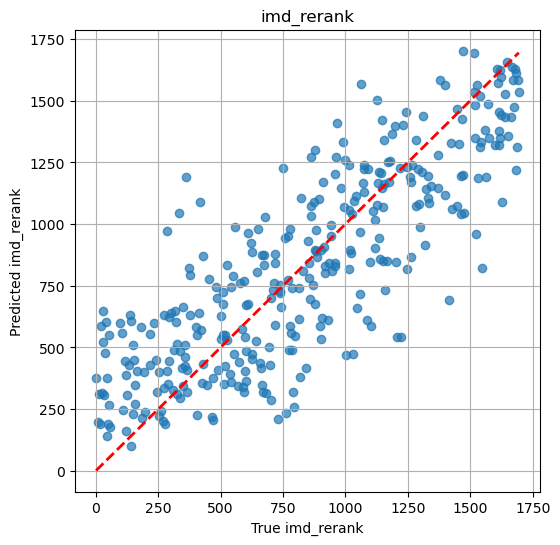

Test set metrics:
  RMSE: 266.994
  MAE: 212.154
  R2: 0.683
  Spearman_rank_corr: 0.820


In [11]:
# Predict on held-out test data
y_pred_test = best_model.predict(X_test)

# Evaluate using the function defined above
test_metrics = evaluate_imd_model(
    y_pred=y_pred_test,
    y_true=y_test,
    column=var_to_predict,
    plot=True)

print("Test set metrics:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.3f}")